### HOMEWORK #2
Jian Wang  
#### Question 1
Given the observation $\vec{Y}$, we model the observations with probability density function $f(\vec{Y}|\theta$).  

(A)  
In frequentist school of thinking, the parameter $\theta$ is god-given, which is unknown but it is a fixed value. All we can do is to find the best proxy ie $\hat{\theta}_{sample}$. But in Bayesian school, the $\theta$ is in the form of probability distribution, which means it relaxe the hard-condition that there is a perfect $\theta$. We can use probability or degree of belief to justify our approximation $\hat{\theta}_{sample}$, which is not a problem of yes or no.

(B)  
For frequentist, we just use the sample to make an approximation of the $\theta$ ie $\hat{\theta_{sample}}$. And then use the law of large number to test, if the $E(\hat{\theta_{sample}}) = 0$. The approximation should be based on population value, which can be represented by sample, ie mean or variance. Then construct a confidence interval to see if $0$ included or not.  
  
From Bayesians, we first assign a model on $\theta$ and then update the probability distribution function of $P(\theta|\vec{Y})$. Once all of our sample data is consumed, we get the posterior probability function about $\theta$. Then we can just check if the distribution overlap $0$, and if not, to check what is the value $P(\theta = 0|\vec{Y})$. If such value is significantly greater than zero, then we need to accept that $\theta=0$. 

(C)  
When the sample size is large enough.


(D)  
For a 95% confidence interval, we means the interval capture the true population parameter $\theta$ for 95% of the time. More precisely, when we are given a large number of samples (realization of $\theta$), we can find that the confidence interval will capture the true $\theta$ with frequence of 0.95.

#### Question #2

(a) Use Monte Carlo methods,rejection sampling, or just try to integrate this function.  
The pseudo-code for Monte Carlo:  
Simulate sample $\{s^{(i)}|i\in{N}\}$ from $p(\theta|\vec{y})$, then compute the sample mean $\sum_{i=0}^{N}(h(s^{i}))$  
  
The pseudo-code for Rejection-sampling:  
step 1: sample from q(\theta|\vec{y}), that is to get simulated value of $g(\theta)$.  
step 2: Use a uniformly distributed value $\mu \in[0,1]$ and compare the result of ${p(\theta|\vec{y})}\over{Mg(\theta)}$ with $\mu$.  
Accept the sample point if $\mu$ is smaller. Otherwise reject the sample points.  
Repeat until enough simulation iteration reached.

(b)  
Use importance sampling.  
  
The pseudo-code:  
Choose a known density distribution $g(\theta)$ and get the unnormalized density distribution $q(\theta|\vec{y})$ Then construct the new probability density function in integral form:  
$E[h(\theta)|\vec{y}] = {{\int_{a}^{b} (h(\theta)* {{q(\theta|\vec{y})}\over{g(\theta)}})g(\theta) d\theta}\over{\int_{a}^{b} {{q(\theta|\vec{y})}\over{g(\theta)}}g(\theta) d\theta}}$.  
Then use sample points from simulation from $g(\theta)$ for $\{s^{(i)}|i\in N\}$ to approximate the above value.
That is ${\sum{h(\theta^s)*w(\theta^s)}}\over{\sum{w(\theta^s)}}$ where $w(\theta^s)={{q(\theta^s|\vec y)}\over{g(\theta^s)}}$

(c)  
Use MCMC process, like Gibbs if we knew the conditional distribution for one parameter over all other parameters.  
Pseudo-code for Gibbs sampling:  
Step1: Randomly choose a $\theta^0$
Then for t>0 simulate the sample from the conditional distribution of parameter j over all other parameters.
Stop when enough sampling points are reached.

(d)  
When we know the distribution of $p(\theta|\vec{y})$ and $q(\theta|\vec{y}) \propto p(\theta|\vec{y})$. Then we should use rejection sampling s.t we can find a constant $M$ such that we will construct a sampling schema with accepting probability of 1.  
The pseudo-code:  
step 1: sample from q(\theta|\vec{y}), that is to get simulated value of $g(\theta)$.  
step 2: Use a uniformly distributed value $\mu \in[0,1]$ and compare the result of ${p(\theta|\vec{y})}\over{Mg(\theta)}$ with $\mu$.  
Accept the sample point if $\mu$ is smaller. Otherwise reject the sample points.  
Repeat until enough simulation iteration reached.

#### Question #3

In [1]:
import pymc3
import numpy as np
import imcmc
from IPython.display import Image

In [260]:
class FakeTrace:
    """Multitrace holder to integrated simply with imcmc and pymc3 API"""
    
    def __init__(self, trace):
        self.chains = list(range(len(trace)))
        self.trace = trace

    def get_values(self, *args,chains = None, **kwargs):
        return self.trace[chains]

def rejection_sampling(image, samples):
    """Rejection sampling """
    
    image_pdf = image / image.sum()
    pdf_max = image_pdf.max()
    height, width = image_pdf.shape
    p_succes = 1 / (height * width * pdf_max)
    actual_samples = min(int(samples / p_succes), int(1e8))
    samples_height = np.random.randint(0, high=height, size=actual_samples)
    samples_width = np.random.randint(0, high=width, size=actual_samples)
    samples_uniform = np.random.uniform(0, 1, size=actual_samples)

    good_samples = [(h, w) for (h, w, u) in zip(samples_height, samples_width, samples_uniform) if
                    (image_pdf[h, w] >= pdf_max * u)]
    
    return FakeTrace([np.array(good_samples)])


def gibbs_sampling(image, samples, nchains, threshold=0.8):
    """Gibbs sampling wrapper"""
    
    image_copy = image.copy()
    if threshold is not None:
        # Might be necessary for good initialization
        image_copy[image < threshold] = 0
        image_copy[image >= threshold] = 1
    
    active_pixels = np.array(list(zip(*np.where(image_copy == image_copy.max()))))
    idx = np.random.randint(0, len(active_pixels), nchains)
    start = active_pixels[idx]

    return FakeTrace([gibbs_sampling_single(image_copy, w_start=start_point[1], samples=samples)
            for start_point in start])


def gibbs_sampling_single(image, w_start, samples):
    """Gibbs sampling for 1 chain"""
    
    image_pdf = image / image.sum()
    height, width = image_pdf.shape
    samples_list = []
    w_current = w_start
    
    for _ in range(samples):
        # sample height
        h_given_w = image_pdf[:, w_current] / image_pdf[:, w_current].sum()
        h_current = np.random.choice(np.array(range(height)), size=1, p=h_given_w)[0]

        # sample width
        w_given_h = image_pdf[h_current, :] / image_pdf[h_current, :].sum()
        w_current = np.random.choice(np.array(range(width)), size=1, p=w_given_h)[0]

        samples_list.append((h_current, w_current))

    return np.array(samples_list)

In [261]:
def main(input_path,
         output_path,
         nchains,
         samples,
         marker,
         markersize,
         leading_point,
         interval,
         colors,
         approach,
         threshold):
    """Main wrapping function."""
    
    image = imcmc.load_image(input_path, 'L')

    if approach == 'rs':
        trace = rejection_sampling(image, samples=samples)
    elif approach == 'gibbs':
        trace = gibbs_sampling(image, samples=samples, nchains=nchains, threshold=threshold)
    elif approach == 'default':
        trace = imcmc.sample_grayscale(image, samples=samples, nchains=nchains, threshold=threshold)
    else:
        raise ValueError('Unrecognized approach')

    # Save as a gif, with the same arguments as above, plus some more
    imcmc.make_gif(trace, image,
                   dpi=30,
                   marker=marker,
                   markersize=markersize,
                   colors=colors,
                   alpha=0.9,
                   leading_point=leading_point,
                   interval=interval,
                   filename=output_path)

In [265]:
input_path = 'manutd.png'
output_path = 'manutd.gif'

approach = 'rs'  # sampling method, 'default'=pymc3 metropolis, 'rs'=rejection sampling, 'gibbs'=gibbs sampling
threshold = 0.1  # image preprocessing, turns light gray into white and dark gray into black -> better initialization
nchains = 4
samples = 10000
marker = '*'
markersize = 4
leading_point =  True  # bool, if True current sampled point has a bigger marker
interval = 30
colors = ['#010101', '#FF0000', '#FFFF00', '#00FF00',"#33FF33",'#0066CC','#CC6600','#663399','#FF00CC','#9900FF',"#303030","#FFFF03"]

MovieWriter imagemagick unavailable. Trying to use pillow instead.


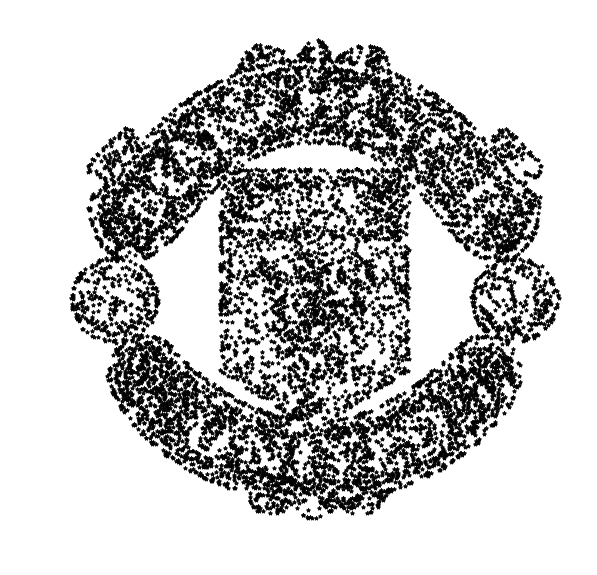

In [266]:
main(input_path=input_path,
             output_path=output_path,
             nchains=nchains,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors,
             approach=approach,
             threshold=threshold)

#### Run the code for 1,2,3,4 chains with Rejection Sampling.

MovieWriter imagemagick unavailable. Trying to use pillow instead.


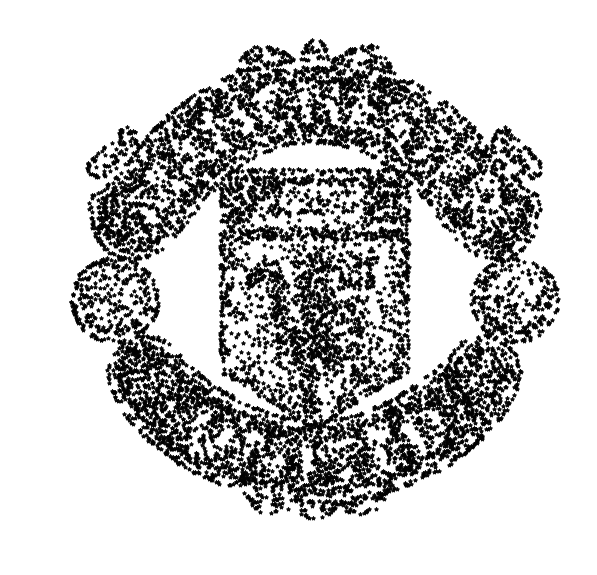

In [267]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


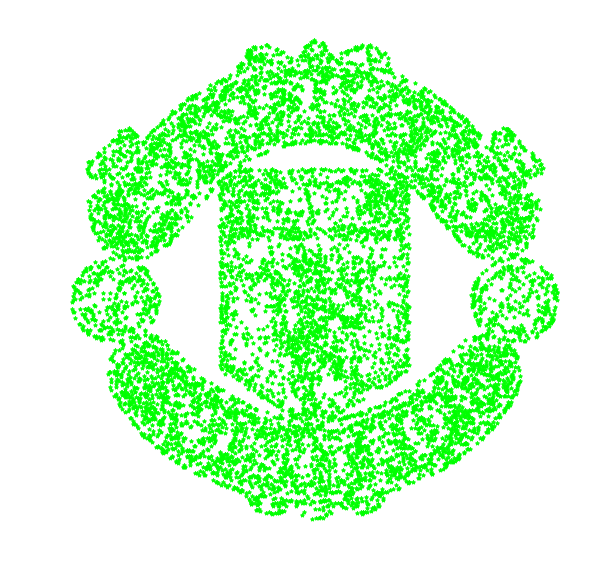

In [268]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


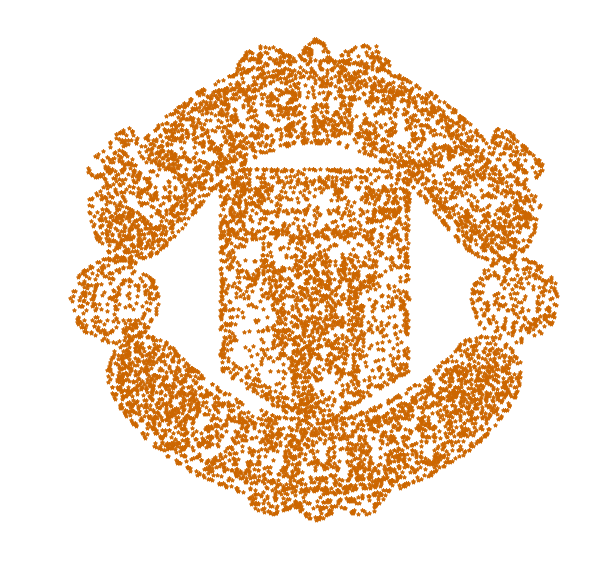

In [269]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


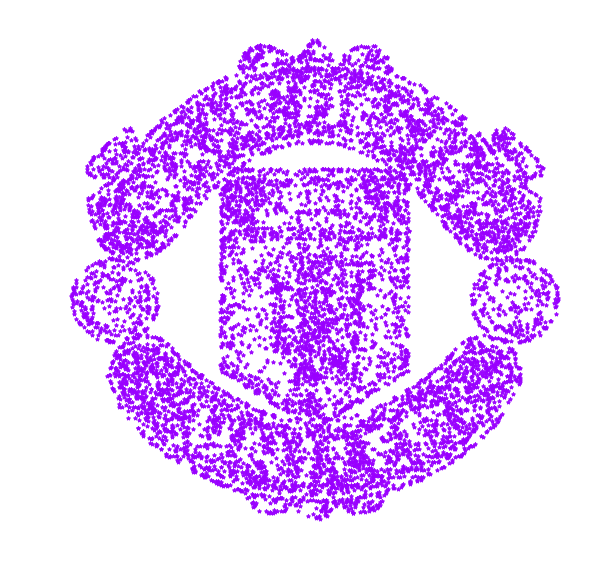

In [270]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

#### Run chains 1,2,3,4 for Gibbs Sampling.

In [271]:
approach = "gibbs"

MovieWriter imagemagick unavailable. Trying to use pillow instead.


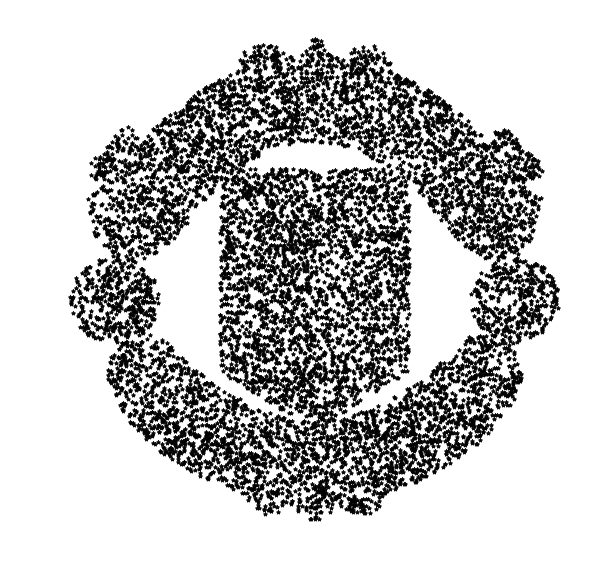

In [272]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


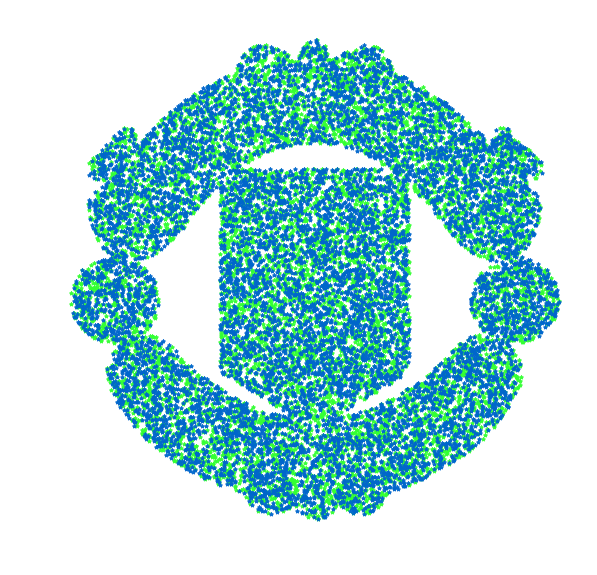

In [275]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[4:6],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


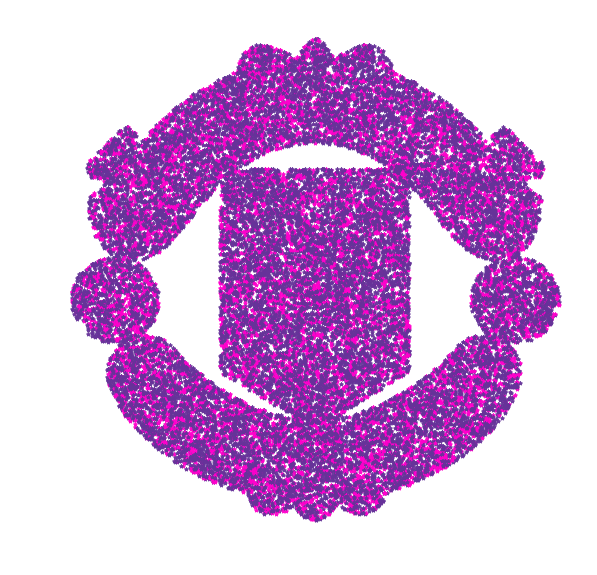

In [276]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[7:9],
             approach=approach,
             threshold=threshold)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


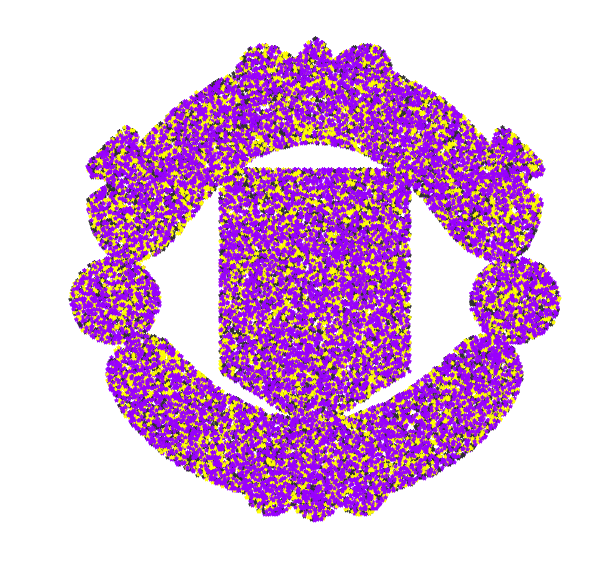

In [277]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

In [278]:
approach = "default"

Sequential sampling (1 chains in 1 job)
Metropolis: [image]
100%|██████████| 10100/10100 [00:01<00:00, 9073.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
MovieWriter imagemagick unavailable. Trying to use pillow instead.


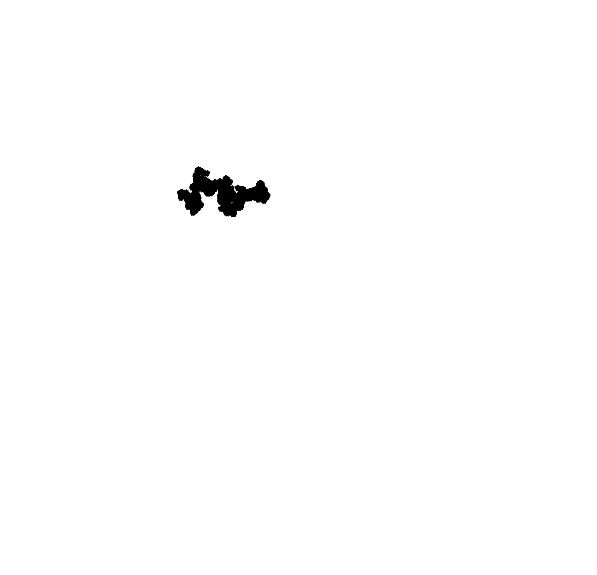

In [279]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [image]
Sampling 2 chains: 100%|██████████| 20200/20200 [00:01<00:00, 11648.96draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
MovieWriter imagemagick unavailable. Trying to use pillow instead.


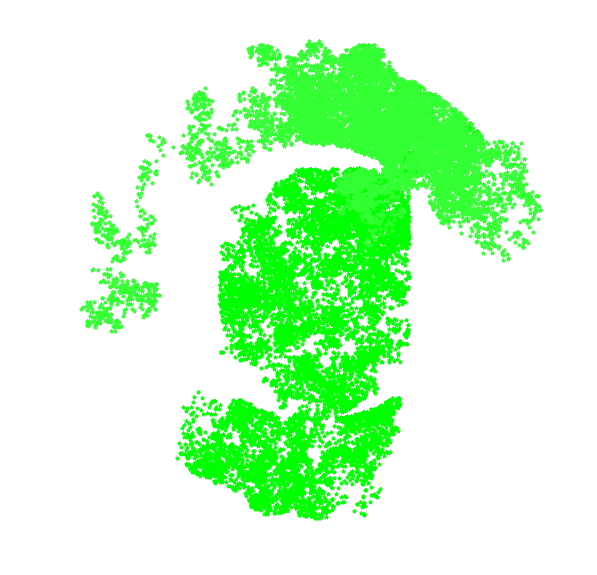

In [280]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)

Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [image]
Sampling 3 chains: 100%|██████████| 30300/30300 [00:03<00:00, 9647.53draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
MovieWriter imagemagick unavailable. Trying to use pillow instead.


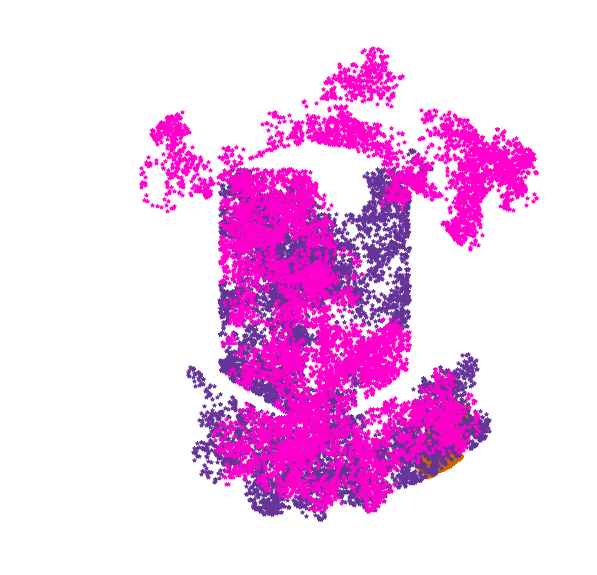

In [281]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [image]
Sampling 4 chains: 100%|██████████| 40400/40400 [00:03<00:00, 10983.21draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
MovieWriter imagemagick unavailable. Trying to use pillow instead.


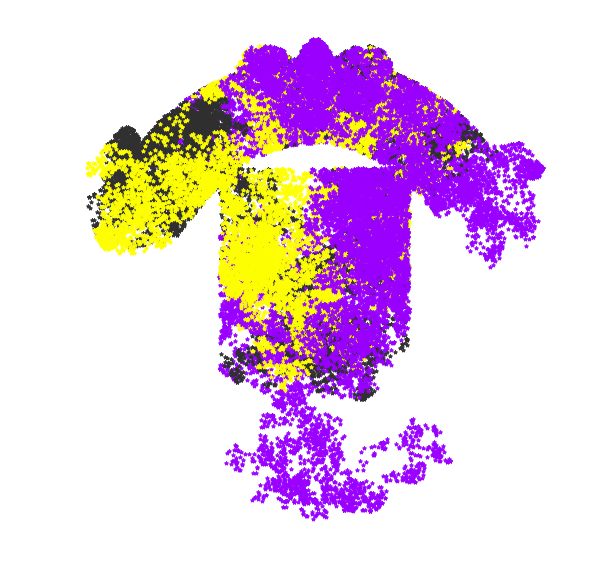

In [282]:
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

(b) To generate the plots for different sample sizes. 100,500,1000,3000.

### Using Rejection Sampling.

MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow inst

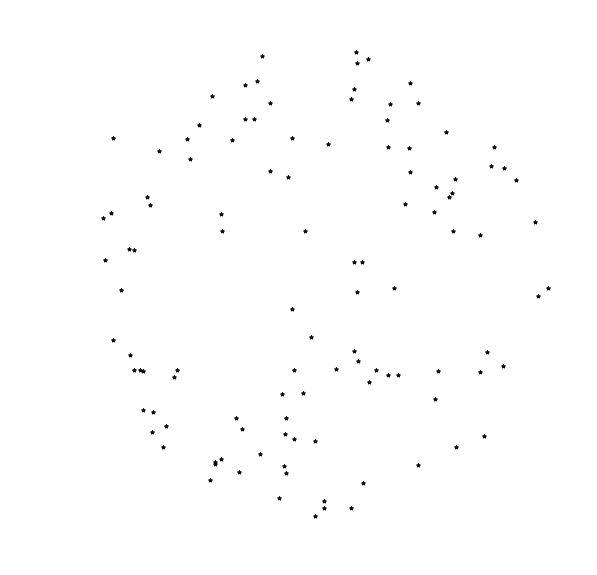

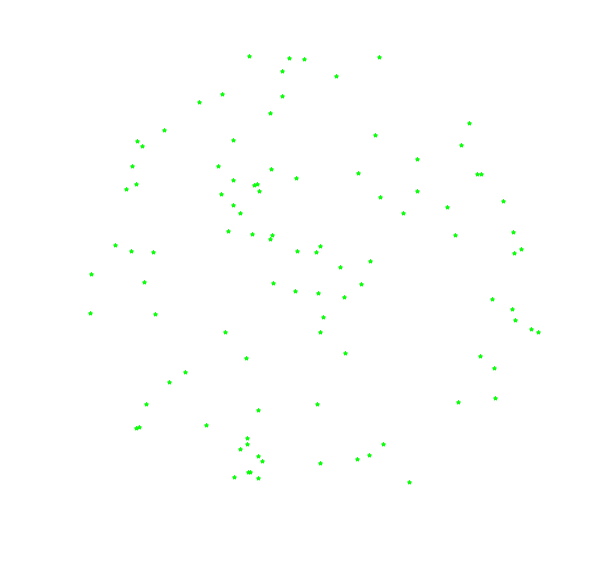

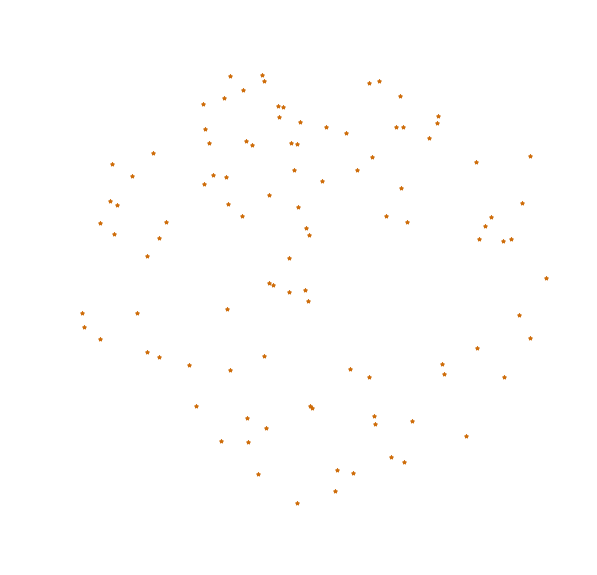

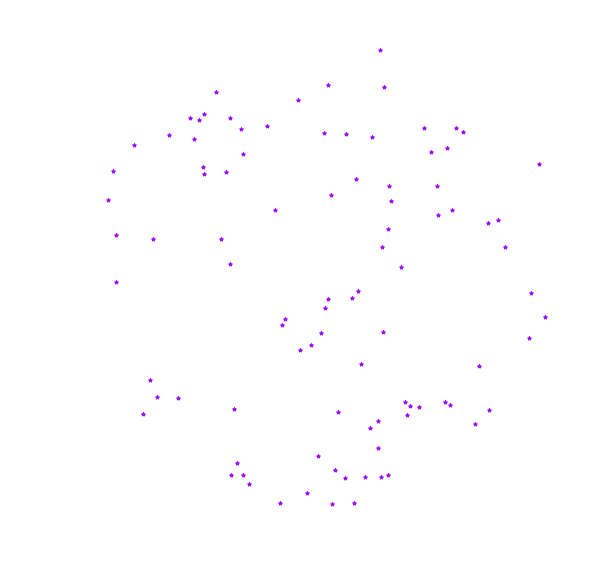

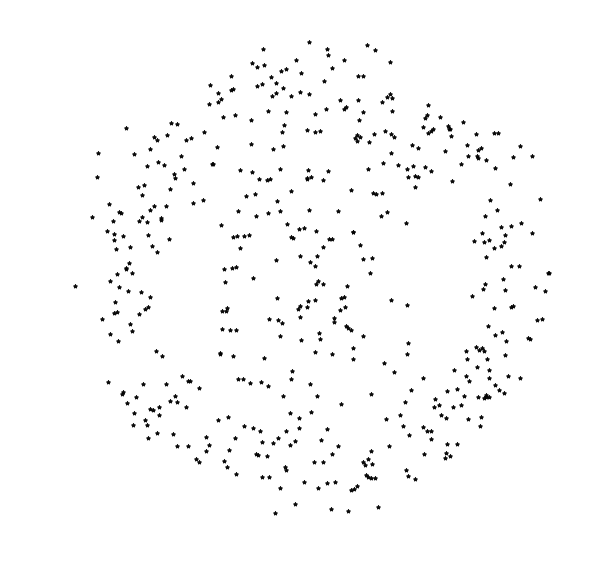

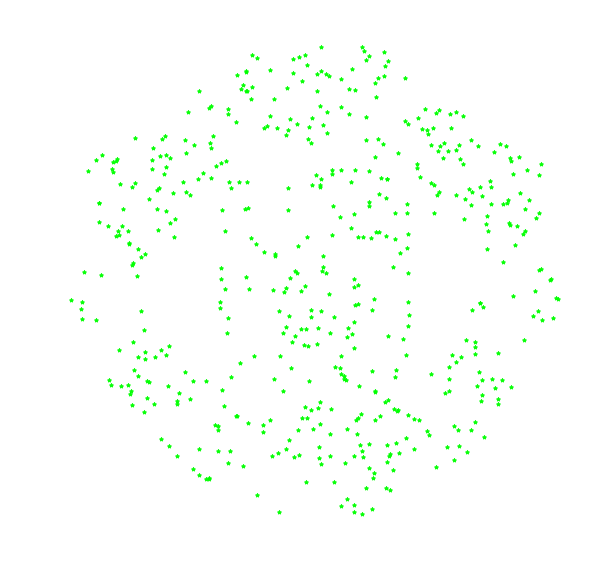

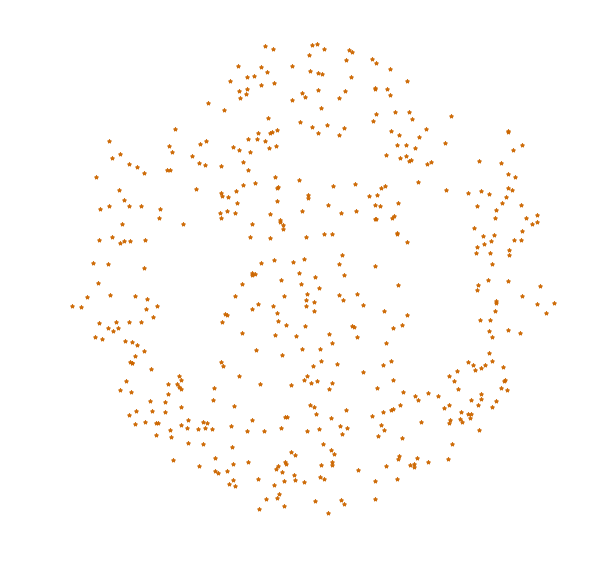

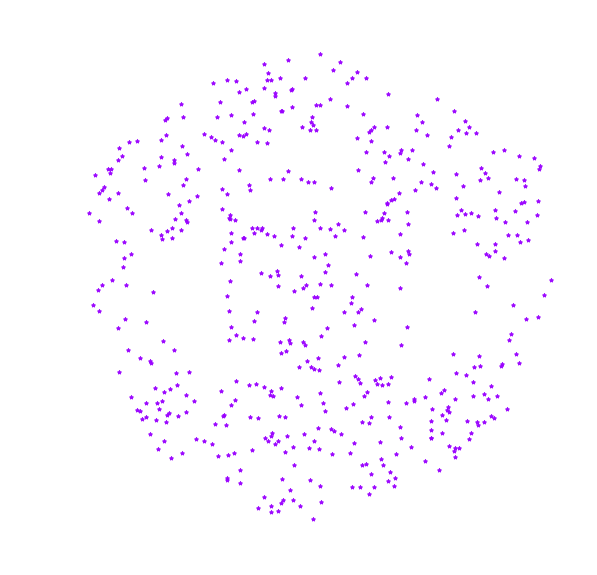

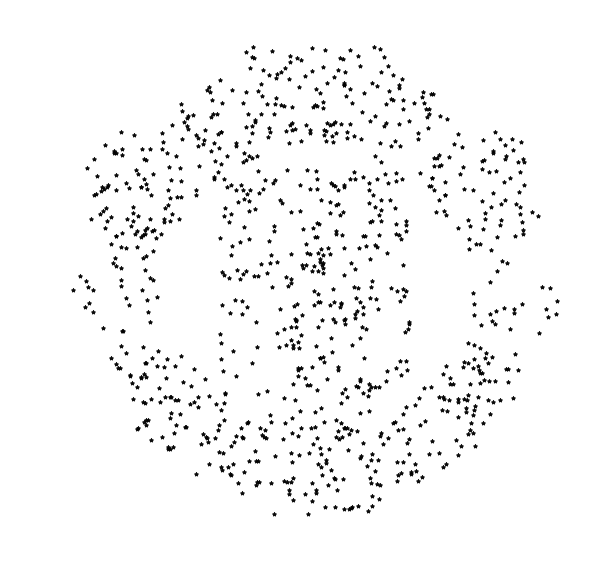

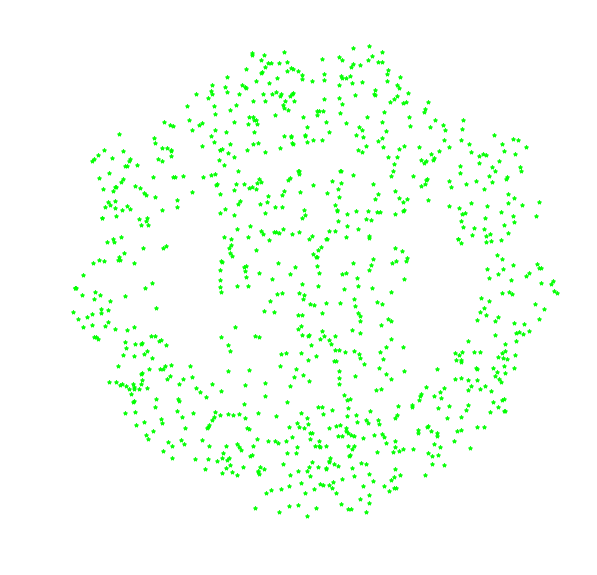

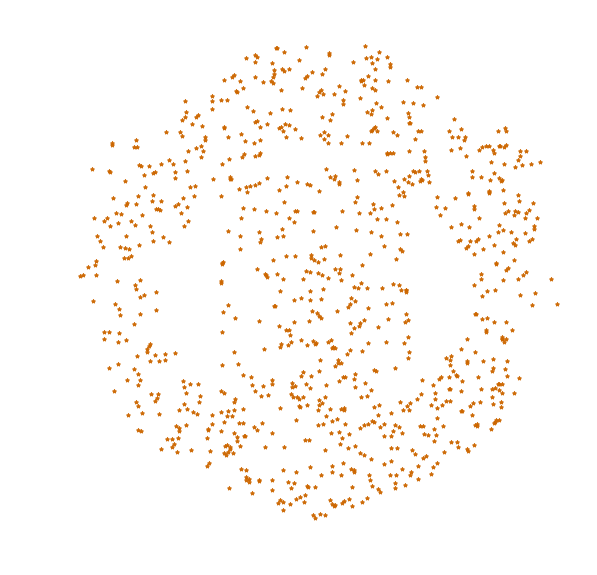

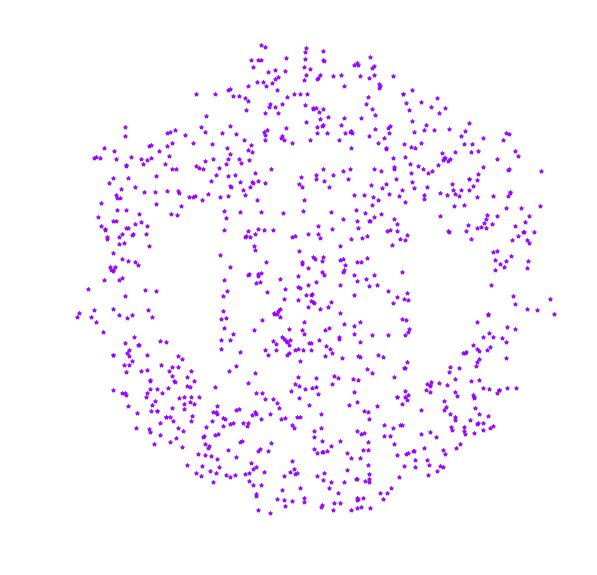

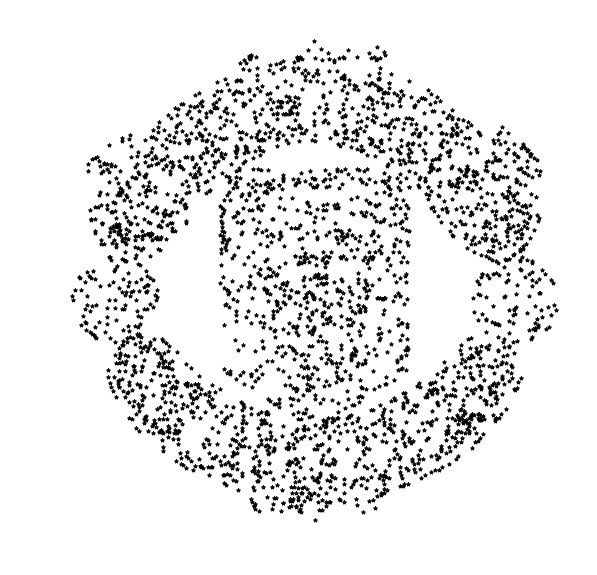

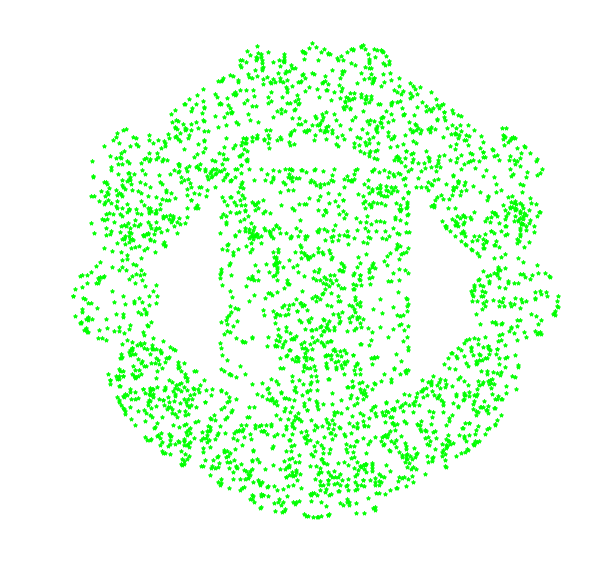

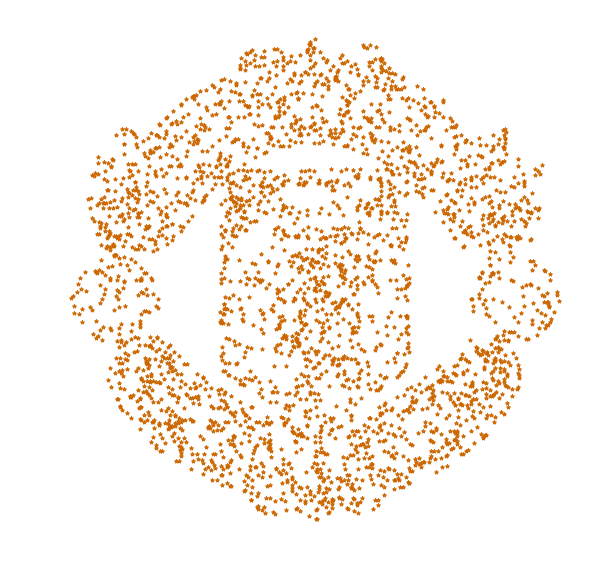

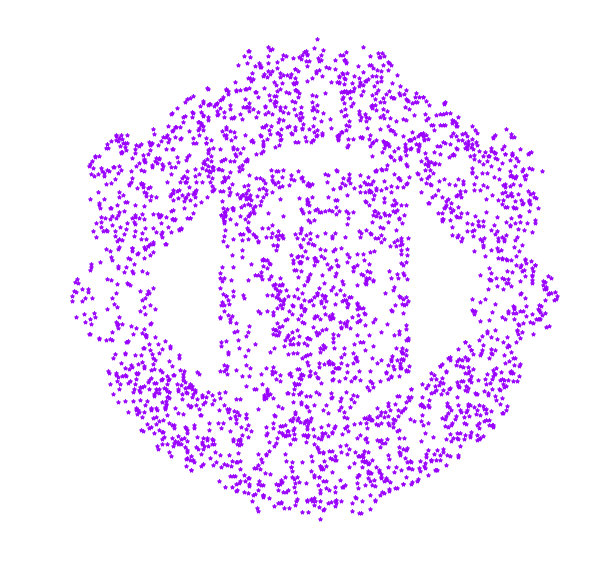

In [287]:
samples = 100
approach = "rs"
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 500
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 1000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 3000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

### Using Gibbs sampling.

MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow inst

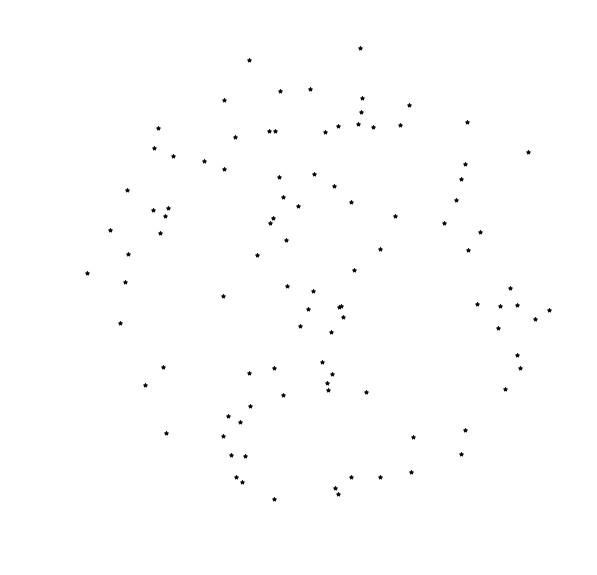

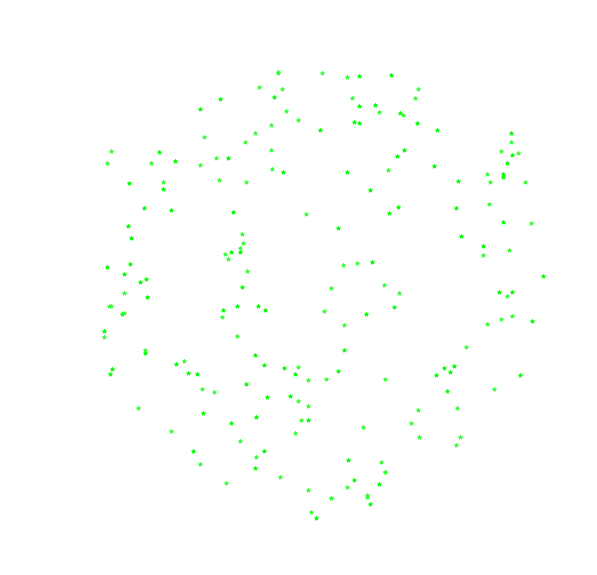

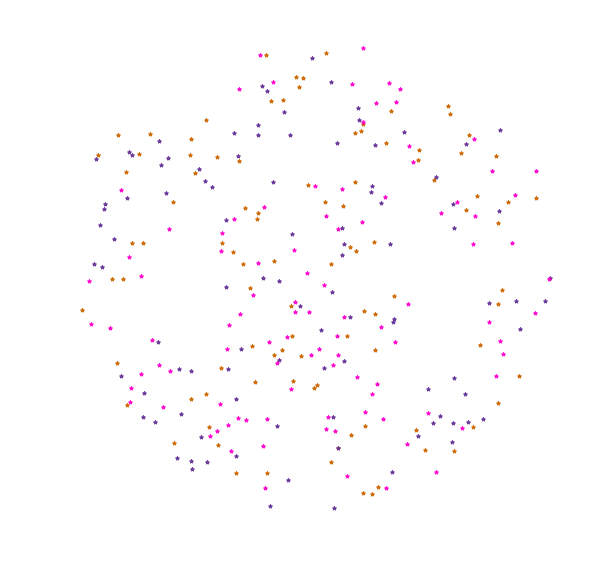

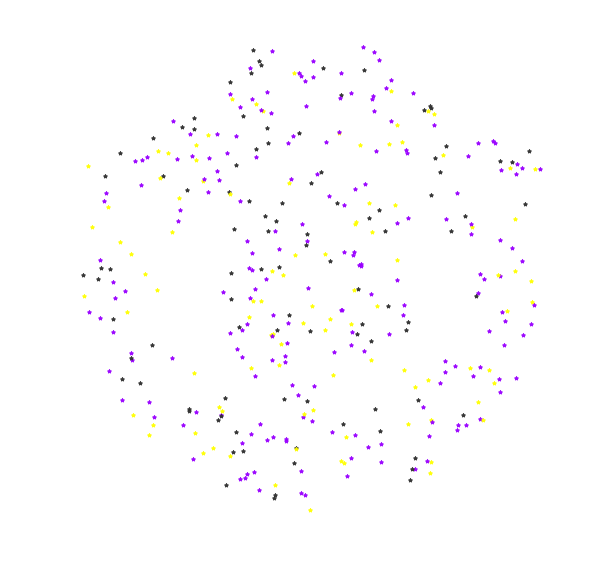

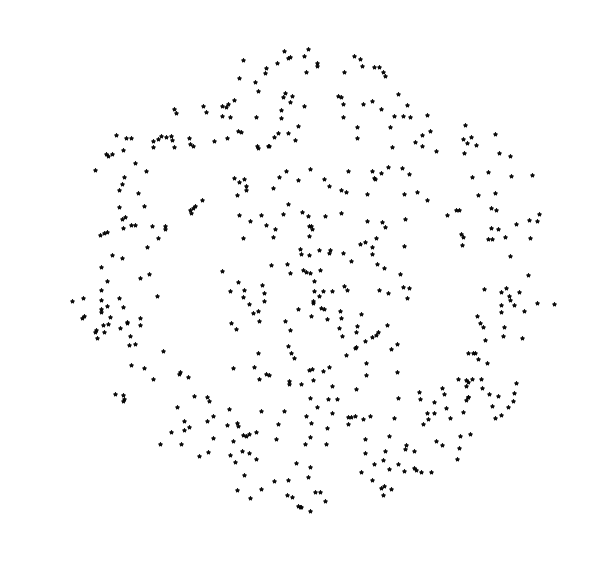

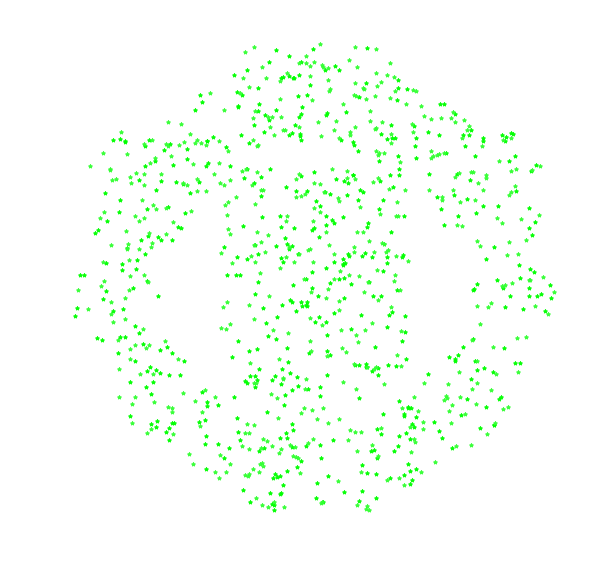

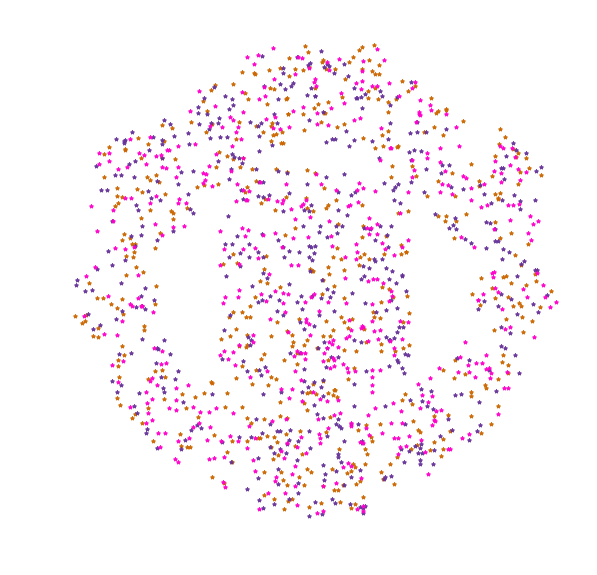

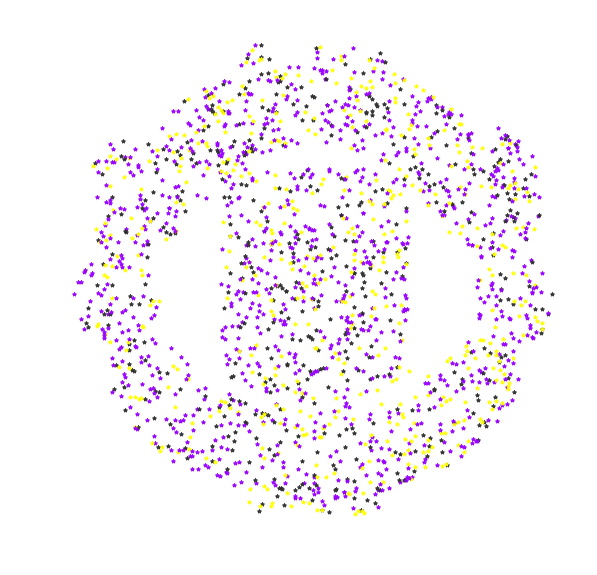

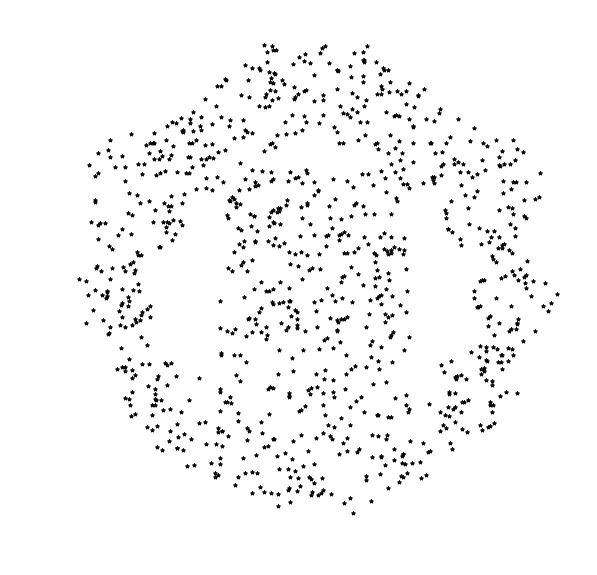

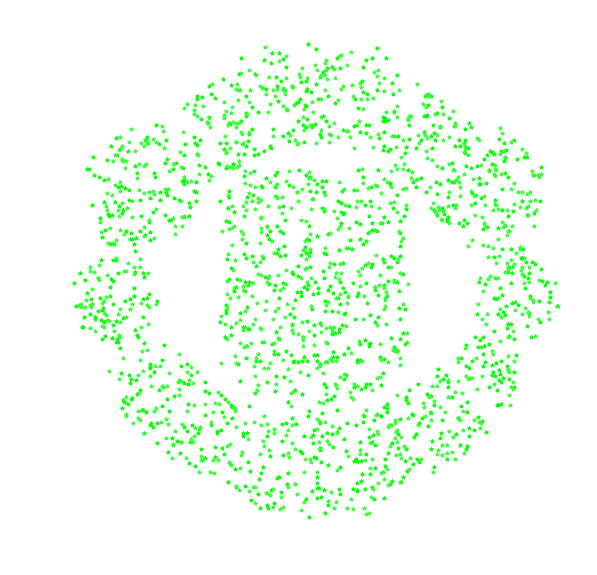

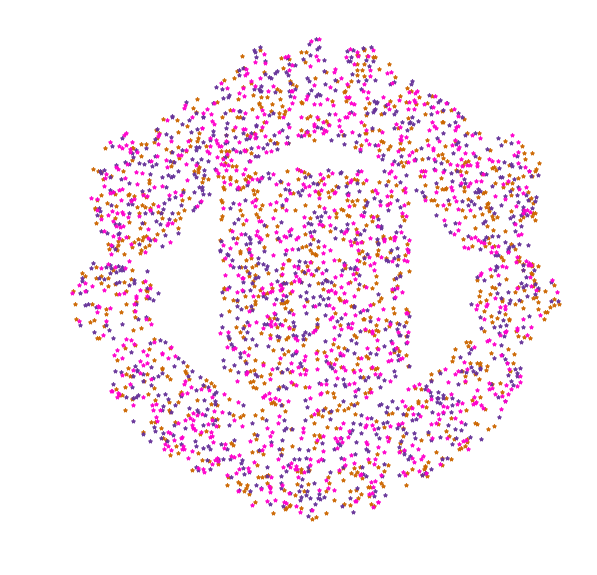

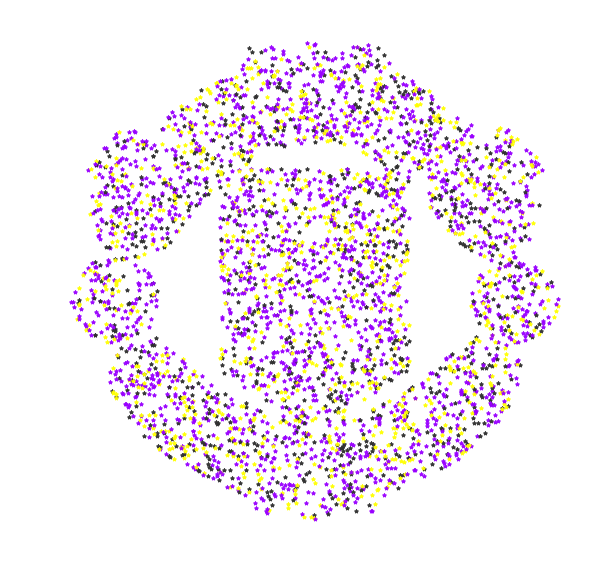

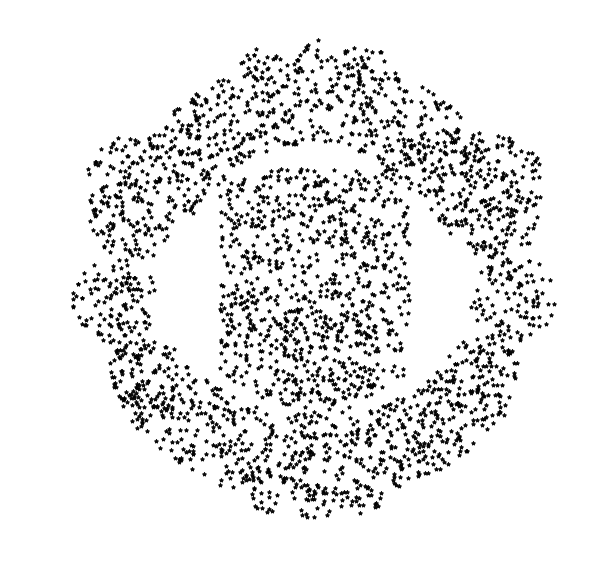

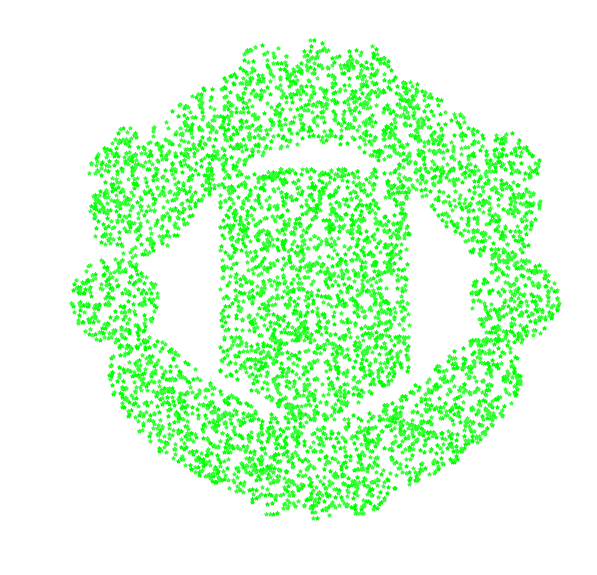

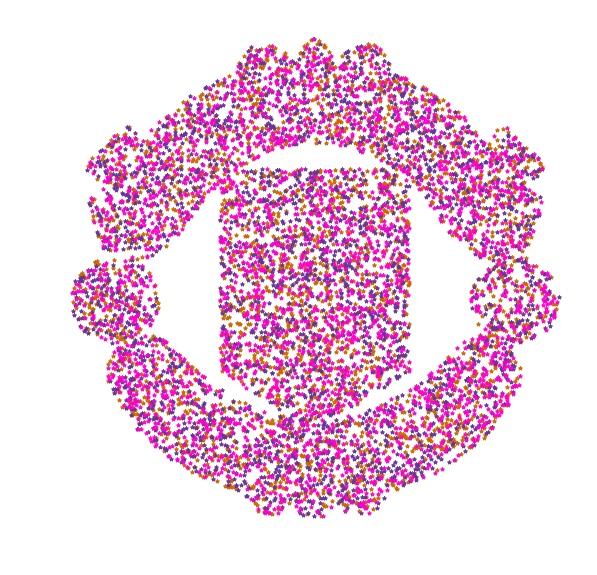

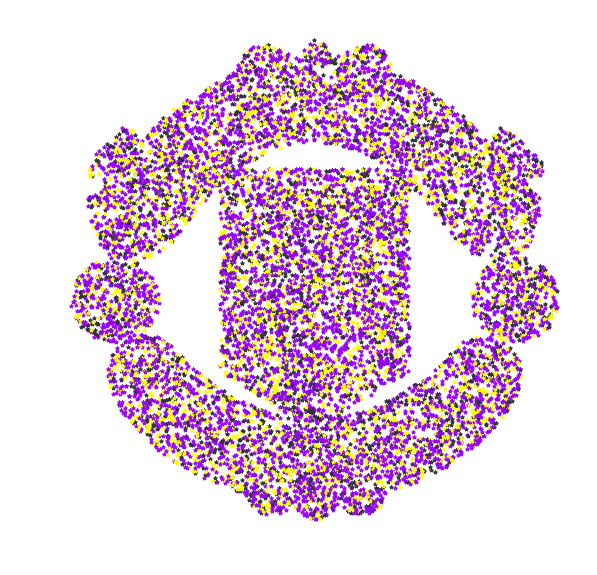

In [288]:
samples = 100
approach = "gibbs"
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 500
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 1000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 3000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

### Using Metropolis-Hasting Sampling

Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [image]
100%|██████████| 200/200 [00:00<00:00, 5897.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
MovieWriter imagemagick unavailable. Trying to use pillow instead.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [image]
Sampling 2 chains: 100%|██████████| 400/400 [00:00<00:00, 6855.17draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
Only 100 samples in chain.
Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [image]
Sampling 3 chains: 100%|██████████| 600/600 [00:00<00:00, 6526.34draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 

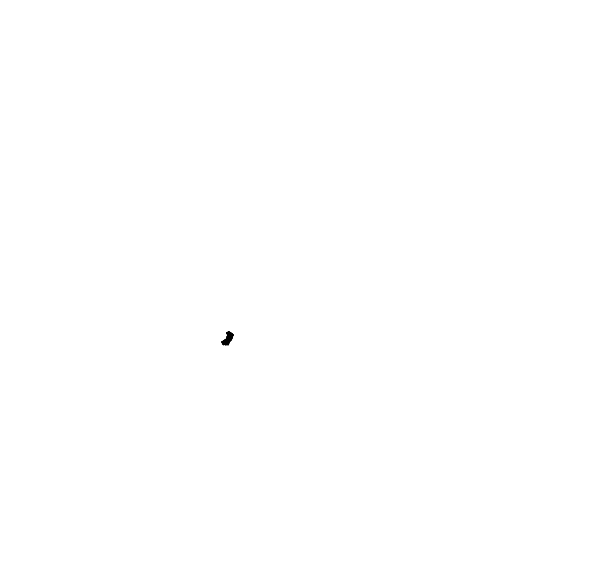

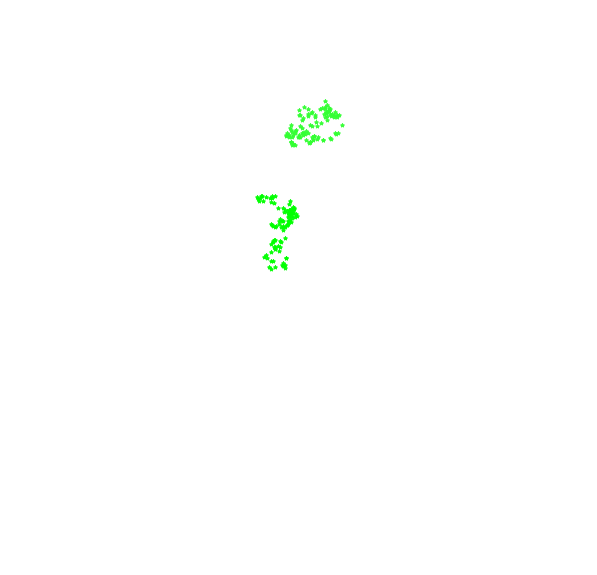

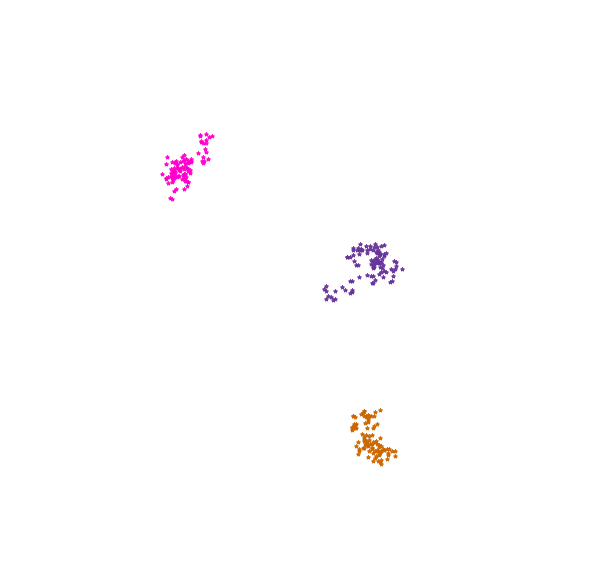

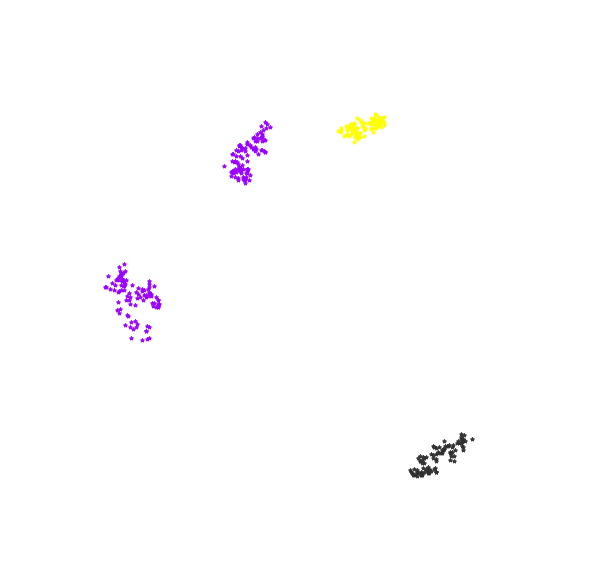

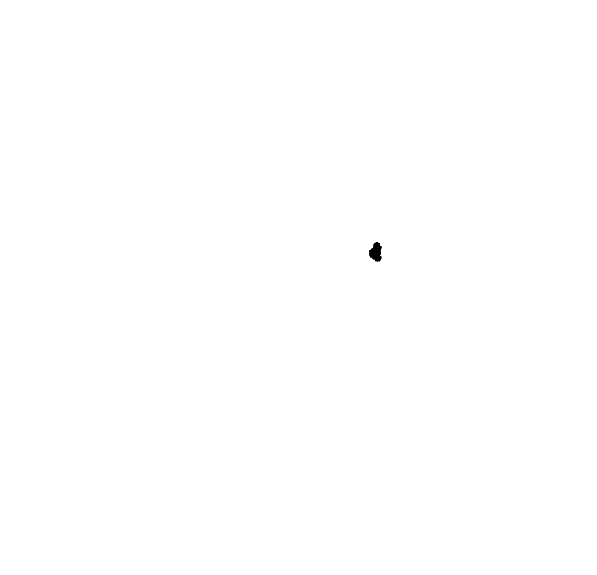

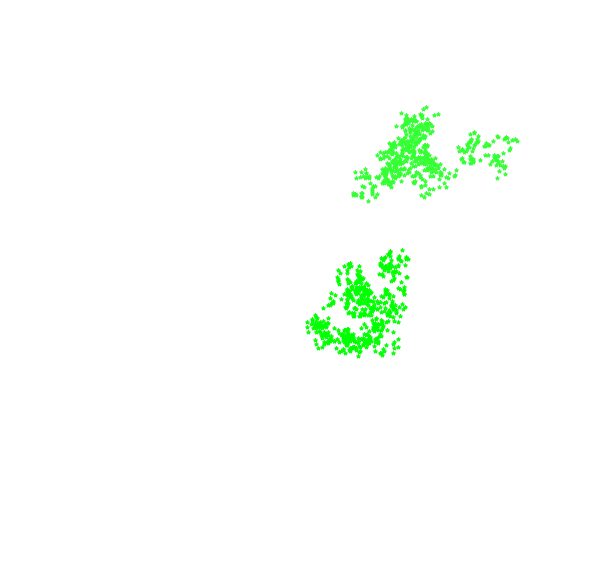

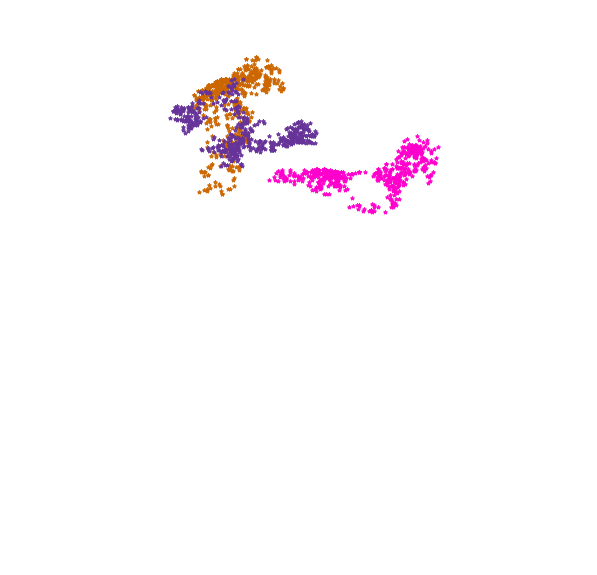

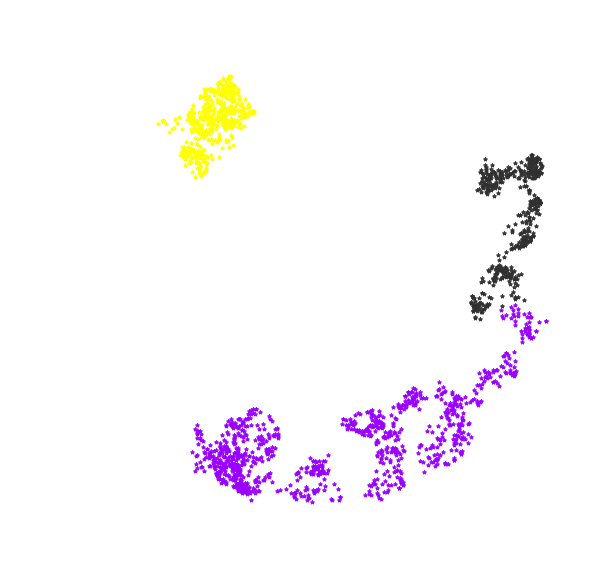

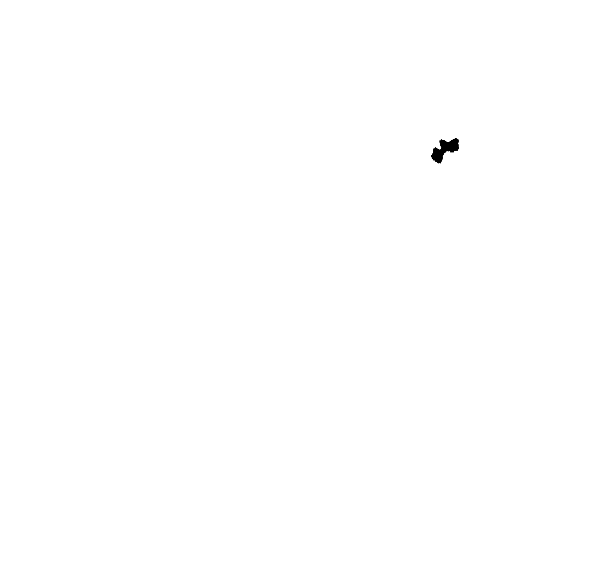

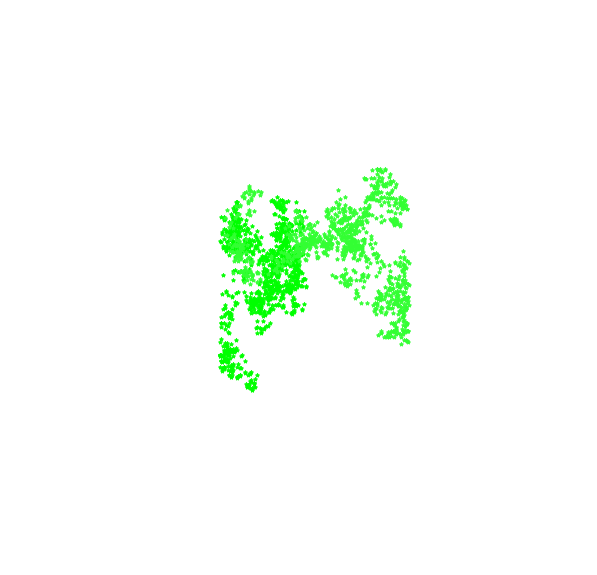

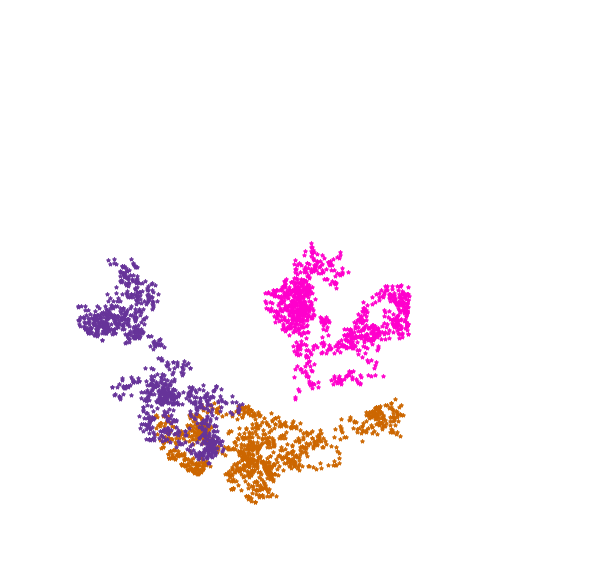

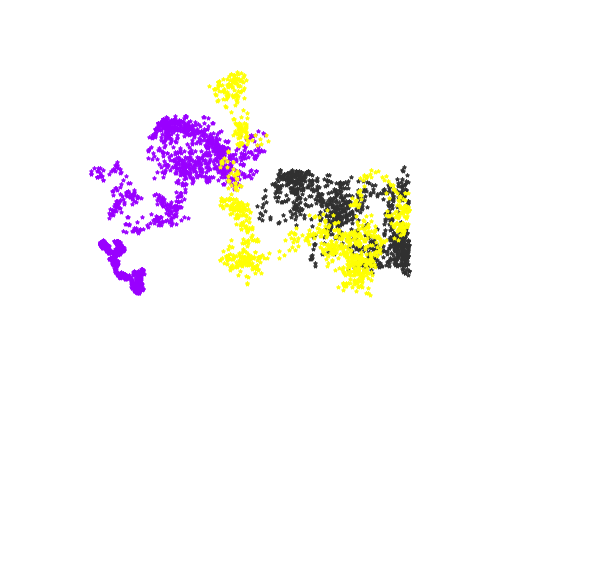

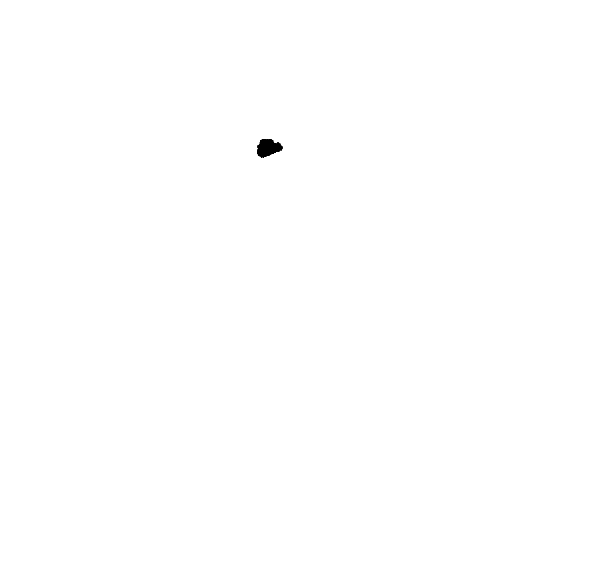

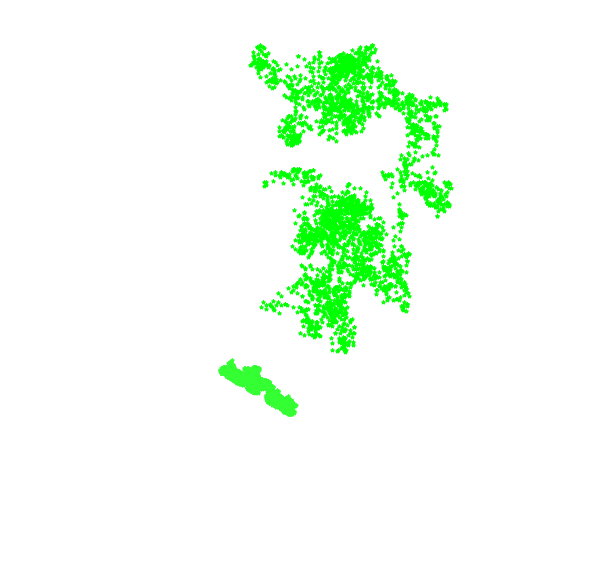

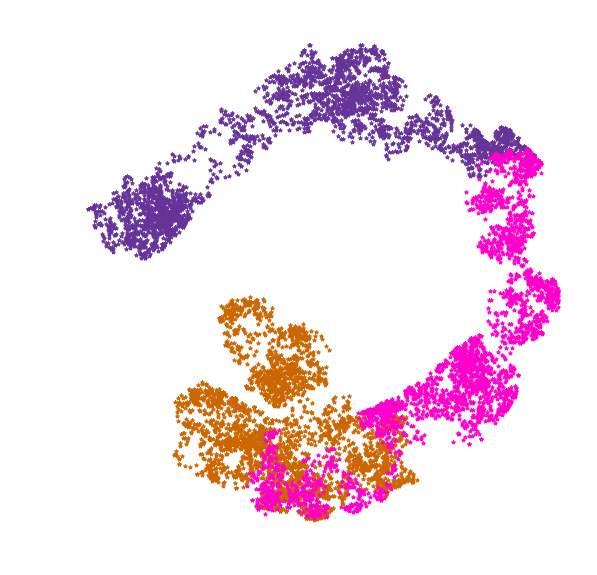

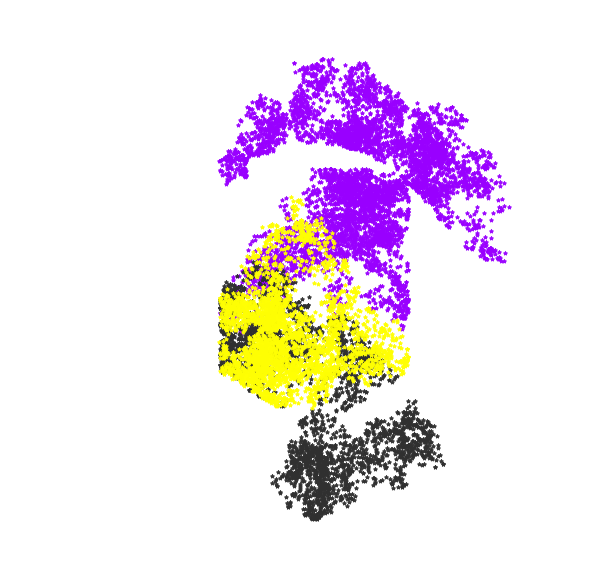

In [289]:
samples = 100
approach = "default"
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 500
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 1000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)
samples = 3000
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=1,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[:3],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=2,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[3:6],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=3,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[6:9],
             approach=approach,
             threshold=threshold)
# run with one chain with first 3 color.
main(input_path=input_path,
             output_path=output_path,
             nchains=4,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors[9:],
             approach=approach,
             threshold=threshold)

#### Question 4

Since the event of supporting Trump before or after the debate is a counting with certain probability of success. So the number of Trump support in any given situation should be modeled as a Binomial(600,p) random variable. Therefore our data generating function is ${f(\vec y|\theta) }\sim{}{Bin(600,\alpha)}$.  
  
For the prior, we only concern the distribution of $\alpha$ which is the probability of supporting Trump. We see that given the pre-debate supporting rate is around $1/3$, we could assume that the prior distribution is $P(\alpha) \sim {Unif}(0.2,1)$.  


In [7]:
import pymc3 as pm

In [29]:
# build up the prior and data generating function.
N = 600
pre_debate = [215,310,75]
after_debate = [280,290,30]

with pm.Model() as model:
    # prior on supporting rate for two phase.
    T_sup_rate_prior = pm.Uniform("T_prior_sup_rate",0.2,1)  # we choose 0.2 as starting point is because the Trump is formidable.
    T_sup_rate_after = pm.Uniform("T_after_sup_rate",0,1)    # we choose 0 as starting point is the public opinion can change drastically.
    
    C_sup_rate_prior = pm.Uniform("C_prior_sup_rate",0.2,1)
    C_sup_rate_after = pm.Uniform("C_after_sup_rate",0,1)
    # The random variable that we are concerned.
    delta = pm.Deterministic("delta", T_sup_rate_after - T_sup_rate_prior)

    # data generating process:
    prior_debate_T = pm.Binomial("prior_debate",N,T_sup_rate_prior,observed=pre_debate[0])
    post_debate_T = pm.Binomial("post_debate",N,T_sup_rate_after,observed=after_debate[0])
    
    prior_debate_C = pm.Binomial("prior_debate_C",N,C_sup_rate_prior,observed=pre_debate[1])
    post_debate_C = pm.Binomial("post_debate_C",N,C_sup_rate_after,observed=after_debate[1])
    
    # Run MCMC process to simulate results from posterior.
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [C_after_sup_rate]
>Metropolis: [C_prior_sup_rate]
>Metropolis: [T_after_sup_rate]
>Metropolis: [T_prior_sup_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6347.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [30]:
# prior_debate_data = burned_trace["prior_debate"]
# post_debate_data = burned_trace["post_debate"]
delta_samples = burned_trace["delta"]

In [31]:
prior_deb_sup = burned_trace["T_prior_sup_rate"]
after_deb_sup = burned_trace["T_after_sup_rate"]

In [33]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

/Users/jw/miniconda3/envs/Bayesian/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


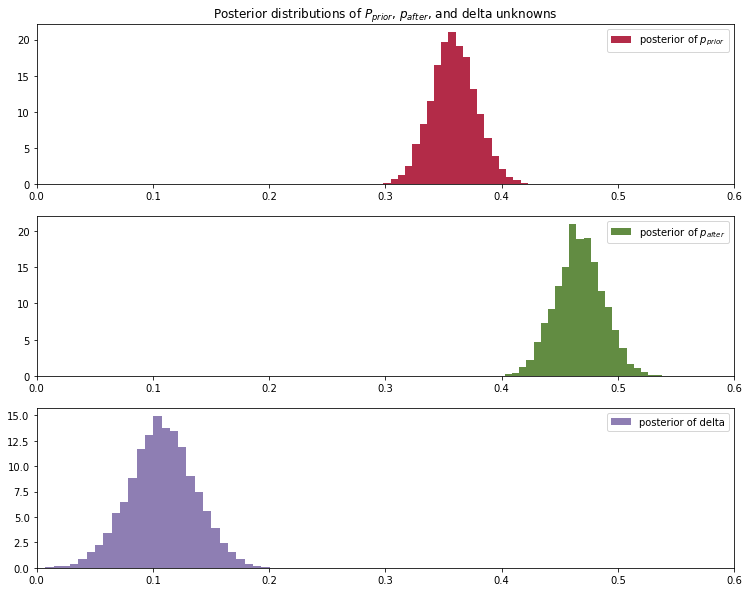

In [34]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0,0.6)
plt.hist(prior_deb_sup, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_{prior}$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $P_{prior}$, $p_{after}$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0,0.6)
plt.hist(after_deb_sup, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_{after}$", color="#467821", normed=True)
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.xlim(0,0.6)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)

plt.legend(loc="upper right");

From above graph, we can see that the distribution of $P_{prior}$ and $P_{after}$ are very different. And we can conclude that there is a shift towards Trump after debate.

In [ ]:
prior_deb_sup_C = burned_trace["C_prior_sup_rate"]
after_deb_sup_C = burned_trace["C_after_sup_rate"]

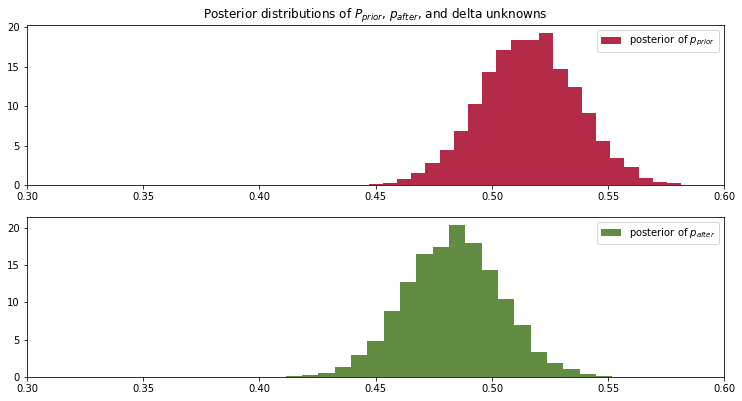

In [36]:
ax = plt.subplot(311)

plt.xlim(0.3,0.6)
plt.hist(prior_deb_sup_C, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_{prior}$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $P_{prior}$, $p_{after}$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.3,0.6)
plt.hist(after_deb_sup_C, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_{after}$", color="#467821", normed=True)
plt.legend(loc="upper right")


We can see that the distribution of supporting rate for Clinton does not change much. Thus the vote Trump get after debates seems to be from Other candidates.

In [257]:
prob_shift_clinton = np.mean(np.array(prior_deb_sup_C)-np.array(after_deb_sup_C))

In [44]:
print("Probability supporting rate change from the debate for Clinton: %.3f" % \
    prob_shift_clinton)

Probability supporting rate change from the debate for Clinton: 0.033


#### Question 5

(a):  
I plan to use a uniform distribution, $Unif(0,2)$. 

(b) The M I would like to take 2 to guarantee the proposal distribution is above the distribution of $p(X)$. We need to make the max value of uniform distribution to be above the highest point of $p(X)$

(c) Doing rejection sampling. Set up the range of M can take. We believe that the M can take up to 10 to be a good upper bound for the value.

In [66]:
M = np.random.randint(2,10,size=100) # the possible value of M to try.
size = 1000 # the sample size we want from the posterior distribution.

In [89]:
def known_function(x):
    """
    Get the actual posterior function value based on input x.
    """
    if x<=0 or x>=2:
        return 0
    elif x<=1:
        return x
    else:
        return 2-x

In [216]:
from datetime import datetime

def rejection_sampling(size,m):
    """
    Rejection sampling 
    param: size is the number of sample you want to have.
    output an np array of sample points.
    counter will be the number to rejection.
    """
    start=datetime.now()
    sample_ls = []
    counter = 0
    for i in range(size):
        condition = False
        while (not condition):
            # get value from posterior.
            u = np.random.uniform(0, 1)
            # get the sampling start point on x.
            x = np.random.uniform(0,2)
            # get the actual function.
            actual_y = known_function(x)
            proposal_y = 0.5 * m
            
            # make rejection
            if u <= ((actual_y*1.0)/proposal_y):
                condition = True
                sample_ls.append((x,u*proposal_y))
            else:
                condition = False
                counter += 1
                 
    run_time = datetime.now()-start
    return sample_ls,counter, run_time

In [254]:
res_ls, ct_ls,rej_ls, time_ls = [], [], [],[]
for m in M[:]:
    res,ct,run_time = rejection_sampling(size*10,m)
    res_ls.append(res)
    rej_ls.append(ct/(ct+size))
    time_ls.append(run_time)
    ct_ls.append(ct)

A proof of concept of our rejection sampling: 

In [233]:
res,ct,a = rejection_sampling(size*10,M[0])
# rej_rate = ct/(ct+1000)

In [234]:
res = np.array(res)

(0, 1.2)

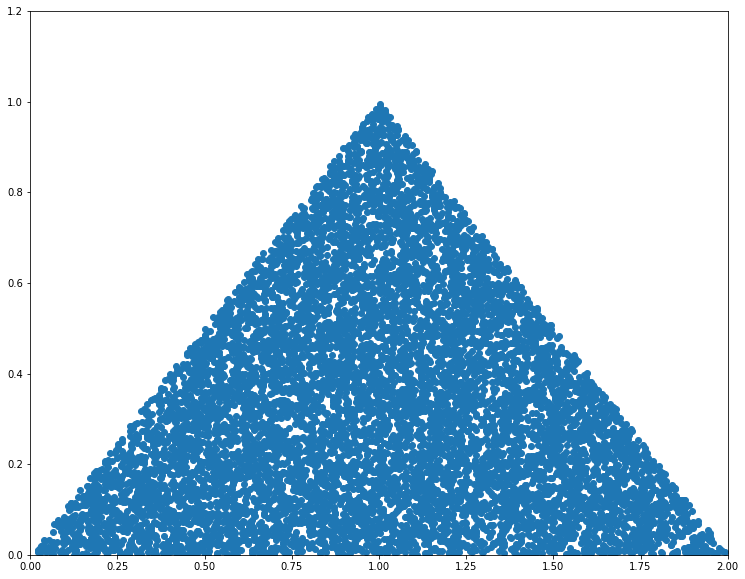

In [236]:
plt.scatter(res[:,0],res[:,1])
plt.xlim(0,2)
plt.ylim(0,1.2)

#### The graph of rejection rate over importance raiot.

Text(0.5, 1.0, 'The rejection ratio over Importance Ratio')

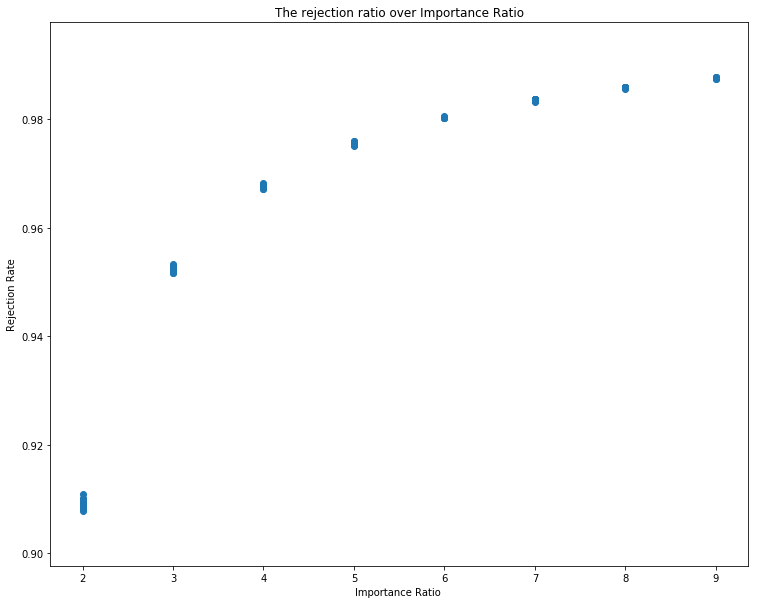

In [242]:
# plot the value of M vs Rejection rate.
plt.scatter(M,rej_ls,marker='o')
plt.xlabel("Importance Ratio ")
plt.ylabel("Rejection Rate")
plt.title("The rejection ratio over Importance Ratio")


We can see that there is a log-like relationship between importance ratio and rejection rate.

In [248]:
time_ls = [ i.total_seconds() for i in time_ls]

Text(0.5, 1.0, 'The running time over Importance Ratio')

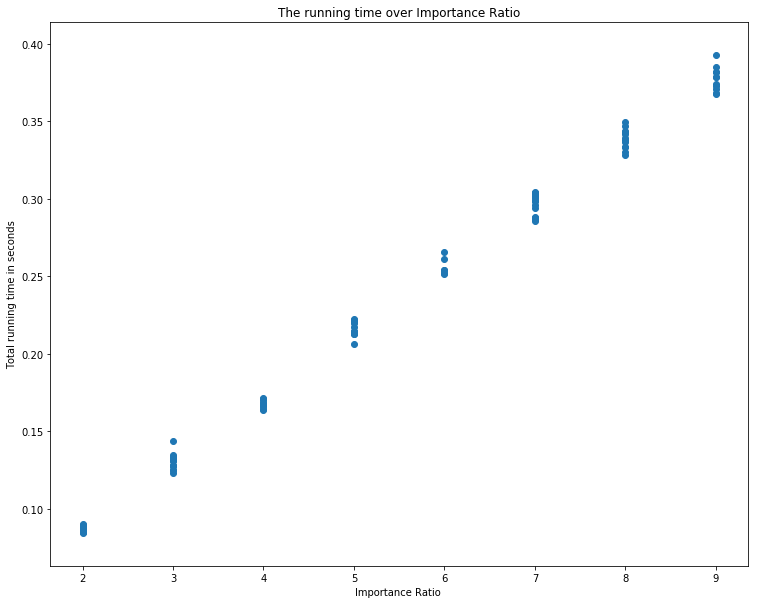

In [251]:
plt.scatter(M,time_ls)
plt.xlabel("Importance Ratio ")
plt.ylabel("Total running time in seconds")
plt.title("The running time over Importance Ratio")

We can see from the previous two plots, that there is a linear relationship between the magnitude of importance ratio and the running time.  
The max value of running time is still small (0.3923 seconds), and the over all running time for 100 different importance ratio is acceptable(23.2s).  
But apparently, the best importance ratio is 4 times faster than the most undesired important ratio. We should be cautious to pick our importance ratio.

In [283]:
# The total number of iteration runs for all these 100 M.
sum(ct_ls)+1000*100

4549263